# Analysis of TRPO

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts

plt.close('all')

delta = 0.2

def read_data(path):
    df = pd.read_csv(path + 'progress.csv')
    iterations = len(df)
    batch_size = df['EpLenMean']
    sigma_1 = []
    sigma_2 = []
    theta = []
    for i in range(iterations):
        policy_params = np.load(path + 'weights_' + str(i) + '.npy')
        #iws = np.load(path + 'iws_' + str(i) + '.npy')
        sigma_1.append(np.exp(policy_params[-2]))
        sigma_2.append(np.exp(policy_params[-1]))
        theta.append(policy_params[0])
    df['Sigma1'] = sigma_1
    df['Sigma2'] = sigma_2
    df['Theta'] = theta
    df['CumAvgRew'] = np.cumsum(df['EpRewMean'])/iterations
    return df

def plot_data(dfs, columns, bottom=-np.infty, top=np.infty, rng=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if type(dfs) is not list:
        dfs = [dfs]
    n_subplots = len(dfs)
    for i in range(n_subplots): 
        df = dfs[i]
        if rng is not None:
            df = df[rng]
        ax.set_xlabel('Iteration')
        x = range(len(df))
        for col in columns:
            y = np.clip(df[col], bottom, top)
            ax.plot(x, y, label=col)
        ax.legend()
    return fig

def plot_ci(mean, std, conf, n_runs):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(mean.index, mean)
    interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
    ax.fill_between(mean.index, interval[0], interval[1], alpha=0.3)
    return fig

# LQG

## Setting:
* Policy mean: linear w/o bias
* Policy std: one logstd parameter
* Available random seeds: 0, 27, 62, 315, 640
* Batch size: 100
* delta = 0.2
* Implementation: baselines
* Task variant: ifqi
* Horizon: 200

### Performance (undiscounted) on 5 different random seeds

**Available data**

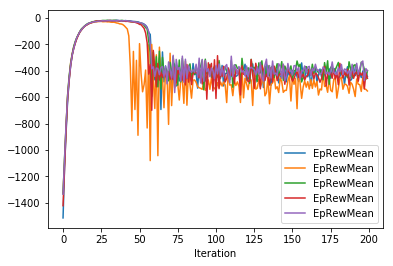

In [32]:
common_path = '../results/trpo/lqg/seed_'
seeds = [0, 27, 62, 315, 640]

dfs = []
for s in seeds:
    dfs.append(read_data(common_path + str(s) + '/'))
plot_data(dfs, ['EpRewMean'])

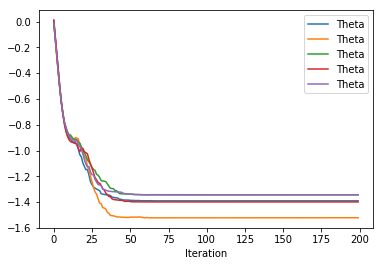

In [33]:
plot_data(dfs, ['Theta'])

In [4]:
n_iter = min(len(df) for df in dfs)
n_runs = len(dfs)
print('Number of runs:', n_runs)
print('Number of iterations per run:', n_iter)

Number of runs: 5
Number of iterations per run: 200


In [5]:
print('Columns:', list(dfs[0]))

Columns: ['TimeElapsed', 'surrgain', 'meankl', 'EpRewMean', 'EpThisIter', 'Step_size', 'entloss', 'DiscEpRewMean', 'optimgain', 'TimestepsSoFar', 'SampleRenyi2', 'J_hat', 'entropy', 'EpLenMean', 'EpisodesSoFar', 'ev_tdlam_before', 'Var_J', 'Sigma1', 'Sigma2', 'CumAvgRew']


In [6]:
concat_df = pd.concat(dfs, axis=1)
mean_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).mean()
std_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).std()

Average performance with 95% confidence intervals:


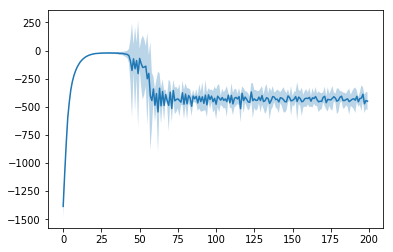

In [7]:
conf = 0.95
print('Average performance with %i%% confidence intervals:' % (conf*100))
mean = mean_df['EpRewMean']
std = std_df['EpRewMean']
plot_ci(mean, std, conf, n_runs)

In [8]:
cum_mean = mean_df['CumAvgRew'][len(mean_df)-1]
cum_std = std_df['CumAvgRew'][len(mean_df)-1]
interval = sts.t.interval(conf, n_runs-1,loc=cum_mean,scale=cum_std/np.sqrt(n_runs))
print('Average cumulative reward: %f, c.i. %s' % (cum_mean, interval))

Average cumulative reward: -353.254707, c.i. (-413.4936266057366, -293.0157867664759)


# Cartpole

## Setting:
* Policy mean: linear with bias
* Policy std: one logstd parameter for each action dimension
* Available random seeds: 0, 27, 62, 315
* Batch size: 100
* delta = 0.2
* Implementation: baselines
* Task variant: gym
* Horizon: 200

### Performance (undiscounted) on 4 different random seeds

**Available data**

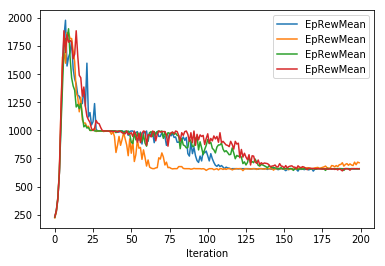

In [9]:
common_path = '../results/trpo/cartpole/seed_'
seeds = [0, 27, 62, 315]

dfs = []
for s in seeds:
    dfs.append(read_data(common_path + str(s) + '/'))
plot_data(dfs, ['EpRewMean'])

In [10]:
n_iter = min(len(df) for df in dfs)
n_runs = len(dfs)
print('Number of runs:', n_runs)
print('Number of iterations per run:', n_iter)

Number of runs: 4
Number of iterations per run: 200


In [11]:
print('Columns:', list(dfs[0]))

Columns: ['ev_tdlam_before', 'entropy', 'surrgain', 'Var_J', 'SampleRenyi2', 'EpRewMean', 'TimestepsSoFar', 'EpisodesSoFar', 'EpThisIter', 'DiscEpRewMean', 'meankl', 'EpLenMean', 'optimgain', 'Step_size', 'J_hat', 'entloss', 'TimeElapsed', 'Sigma1', 'Sigma2', 'CumAvgRew']


In [12]:
concat_df = pd.concat(dfs, axis=1)
mean_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).mean()
std_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).std()

Average performance with 95% confidence intervals:


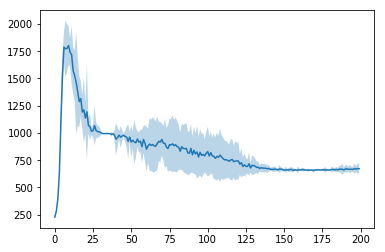

In [13]:
conf = 0.95
print('Average performance with %i%% confidence intervals:' % (conf*100))
mean = mean_df['EpRewMean']
std = std_df['EpRewMean']
plot_ci(mean, std, conf, n_runs)

In [14]:
cum_mean = mean_df['CumAvgRew'][len(mean_df)-1]
cum_std = std_df['CumAvgRew'][len(mean_df)-1]
interval = sts.t.interval(conf, n_runs-1,loc=cum_mean,scale=cum_std/np.sqrt(n_runs))
print('Average cumulative reward: %f, c.i. %s' % (cum_mean, interval))

Average cumulative reward: 842.580166, c.i. (768.5128397220869, 916.6474924918234)


# Swimmer

## Setting:
* Policy mean: 64x64 tanh with biases
* Policy std: one logstd parameter for each action dimension
* Available random seeds: 0, 27, 62, 315, 640
* Batch size: 100
* delta = 0.2
* Implementation: baselines
* Task variant: gym
* Horizon: 500

### Performance (undiscounted) on 5 different random seeds

**Available data**

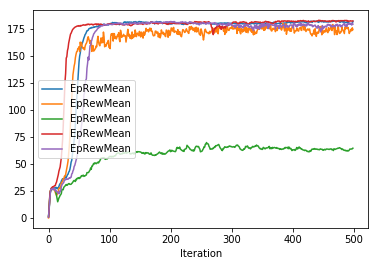

In [15]:
common_path = '../results/trpo/swimmer/seed_'
seeds = [0, 27, 62, 315, 640]

dfs = []
for s in seeds:
    dfs.append(read_data(common_path + str(s) + '/'))
plot_data(dfs, ['EpRewMean'])

In [16]:
n_iter = min(len(df) for df in dfs)
n_runs = len(dfs)
print('Number of runs:', n_runs)
print('Number of iterations per run:', n_iter)

Number of runs: 5
Number of iterations per run: 500


In [17]:
print('Columns:', list(dfs[0]))

Columns: ['Var_J', 'Step_size', 'J_hat', 'DiscEpRewMean', 'EpisodesSoFar', 'EpLenMean', 'SampleRenyi2', 'EpThisIter', 'TimestepsSoFar', 'TimeElapsed', 'entropy', 'entloss', 'meankl', 'surrgain', 'optimgain', 'EpRewMean', 'ev_tdlam_before', 'Sigma1', 'Sigma2', 'CumAvgRew']


In [18]:
concat_df = pd.concat(dfs, axis=1)
mean_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).mean()
std_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).std()

Average performance with 95% confidence intervals:


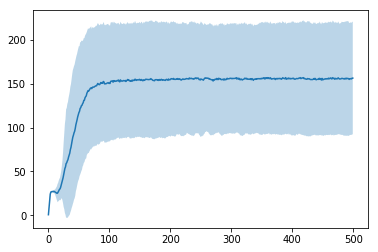

In [19]:
conf = 0.95
print('Average performance with %i%% confidence intervals:' % (conf*100))
mean = mean_df['EpRewMean']
std = std_df['EpRewMean']
plot_ci(mean, std, conf, n_runs)

In [20]:
cum_mean = mean_df['CumAvgRew'][len(mean_df)-1]
cum_std = std_df['CumAvgRew'][len(mean_df)-1]
interval = sts.t.interval(conf, n_runs-1,loc=cum_mean,scale=cum_std/np.sqrt(n_runs))
print('Average cumulative reward: %f, c.i. %s' % (cum_mean, interval))

Average cumulative reward: 143.649772, c.i. (83.82191534457617, 203.47762844958555)
